In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
# Define the coRNNCell
class coRNNCell(nn.Module):
    def __init__(self, n_inp, n_hid, dt, gamma, epsilon):
        super(coRNNCell, self).__init__()
        self.dt = dt
        self.gamma = gamma
        self.epsilon = epsilon
        self.i2h = nn.Linear(n_inp + n_hid + n_hid, n_hid)

    def forward(self, x, hy, hz):
        hz = hz + self.dt * (torch.tanh(self.i2h(torch.cat((x, hz, hy), 1)))
                             - self.gamma * hy - self.epsilon * hz)
        hy = hy + self.dt * hz

        return hy, hz

# Define the coRNN model
class coRNN(nn.Module):
    def __init__(self, n_inp, n_hid, n_out, dt, gamma, epsilon):
        super(coRNN, self).__init__()
        self.n_hid = n_hid
        self.cell = coRNNCell(n_inp, n_hid, dt, gamma, epsilon)
        self.readout = nn.Linear(n_hid, n_out)

    def forward(self, x):
        hy = torch.zeros(x.size(1), self.n_hid)
        hz = torch.zeros(x.size(1), self.n_hid)

        for t in range(x.size(0)):
            hy, hz = self.cell(x[t], hy, hz)
        output = self.readout(hy)

        return output


### PINN data importing

In [2]:
# Load the .mat file
mat_data = scipy.io.loadmat('burg.mat')

# Access the variables stored in the .mat file
# The variable names in the .mat file become keys in the loaded dictionary
x = mat_data['x']
t = mat_data['t']
u = mat_data['u1']



### Exact Solution data importing

x size (256, 1)
t size (100, 1)
u size (256, 100)


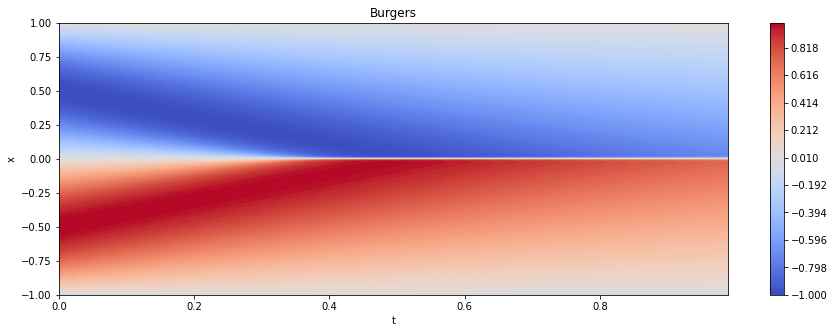

In [3]:
# importing data

import torch
import torch.nn as nn
import numpy as np
import time
import scipy.io

# Load the .mat file
mat_data = scipy.io.loadmat('burgers_shock.mat')

# Access the variables stored in the .mat file
# The variable names in the .mat file become keys in the loaded dictionary
x = mat_data['x']
t = mat_data['t']
u_1 = mat_data['usol']

#Use the loaded variables as needed
print("x size", x.shape)
print("t size", t.shape)
print("u size", u.shape)

X, T = np.meshgrid(x, t)
# Define custom color levels
c_levels = np.linspace(np.min(u_1), np.max(u_1), 100)

# Plot the contour
plt.figure(figsize=(15, 5))
plt.contourf(T, X, u_1.T, levels=c_levels, cmap='coolwarm')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Burgers')
plt.colorbar()  # Add a colorbar for the contour levels
plt.show()

In [4]:
# Toy problem data
input_size = 256
hidden_size = 32
output_size = 256
sequence_length = 79
batch_size = 1
num_epochs = 20000


# Set random seed for reproducibility
#torch.manual_seed(42)



input_data = u[:,0:79]
target_data = u[:,1:80]

test_data = u[:,79]
#test_target = u[:,80:100]


# Convert data to tensors
input_tensor = torch.tensor(input_data.T).view(batch_size, sequence_length, input_size).float()
target_tensor = torch.tensor(target_data.T).view(batch_size, sequence_length, output_size).float()

# Convert test data to tensors
test_tensor = torch.tensor(test_data.T).view(batch_size, 1, input_size).float()
#test_target_tensor = torch.tensor(test_target.T).view(batch_size, 20, output_size).float()

# Create coRNN instance
cornn = coRNN(input_size, hidden_size, output_size, dt=0.1, gamma=10, epsilon= 2)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cornn.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    # Forward pass
    output = cornn(input_tensor)
    loss = criterion(output, target_tensor)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item():.8f}')


with torch.no_grad():
    prediction = cornn(test_tensor)

print(prediction.shape)

final_time_output = prediction[-1, :]
print(final_time_output.shape)

final_out = final_time_output.detach().numpy().reshape(-1,1)
final_true = u[:,-1].reshape(-1,1)



/data/localhome/tkapoor/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 79, 256])) that is different to the input size (torch.Size([79, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 10/20000, Loss: 0.40657699
Epoch: 20/20000, Loss: 0.39165229
Epoch: 30/20000, Loss: 0.37714112
Epoch: 40/20000, Loss: 0.36311805
Epoch: 50/20000, Loss: 0.34962356
Epoch: 60/20000, Loss: 0.33664620
Epoch: 70/20000, Loss: 0.32416299
Epoch: 80/20000, Loss: 0.31214893
Epoch: 90/20000, Loss: 0.30058074
Epoch: 100/20000, Loss: 0.28943807
Epoch: 110/20000, Loss: 0.27870274
Epoch: 120/20000, Loss: 0.26835850
Epoch: 130/20000, Loss: 0.25839061
Epoch: 140/20000, Loss: 0.24878530
Epoch: 150/20000, Loss: 0.23952977
Epoch: 160/20000, Loss: 0.23061195
Epoch: 170/20000, Loss: 0.22202043
Epoch: 180/20000, Loss: 0.21374433
Epoch: 190/20000, Loss: 0.20577317
Epoch: 200/20000, Loss: 0.19809704
Epoch: 210/20000, Loss: 0.19070624
Epoch: 220/20000, Loss: 0.18359156
Epoch: 230/20000, Loss: 0.17674398
Epoch: 240/20000, Loss: 0.17015491
Epoch: 250/20000, Loss: 0.16381593
Epoch: 260/20000, Loss: 0.15771894
Epoch: 270/20000, Loss: 0.15185599
Epoch: 280/20000, Loss: 0.14621949
Epoch: 290/20000, Loss: 0.140

Epoch: 2500/20000, Loss: 0.00974930
Epoch: 2510/20000, Loss: 0.00964159
Epoch: 2520/20000, Loss: 0.00953633
Epoch: 2530/20000, Loss: 0.00943316
Epoch: 2540/20000, Loss: 0.00933190
Epoch: 2550/20000, Loss: 0.00923243
Epoch: 2560/20000, Loss: 0.00913468
Epoch: 2570/20000, Loss: 0.00903856
Epoch: 2580/20000, Loss: 0.00894401
Epoch: 2590/20000, Loss: 0.00885097
Epoch: 2600/20000, Loss: 0.00875939
Epoch: 2610/20000, Loss: 0.00866921
Epoch: 2620/20000, Loss: 0.00858038
Epoch: 2630/20000, Loss: 0.00849283
Epoch: 2640/20000, Loss: 0.00840644
Epoch: 2650/20000, Loss: 0.00832027
Epoch: 2660/20000, Loss: 0.00816669
Epoch: 2670/20000, Loss: 0.00800053
Epoch: 2680/20000, Loss: 0.00789688
Epoch: 2690/20000, Loss: 0.00779982
Epoch: 2700/20000, Loss: 0.00770650
Epoch: 2710/20000, Loss: 0.00761563
Epoch: 2720/20000, Loss: 0.00752678
Epoch: 2730/20000, Loss: 0.00743972
Epoch: 2740/20000, Loss: 0.00735434
Epoch: 2750/20000, Loss: 0.00727056
Epoch: 2760/20000, Loss: 0.00718828
Epoch: 2770/20000, Loss: 0.0

Epoch: 4950/20000, Loss: 0.00059587
Epoch: 4960/20000, Loss: 0.00059071
Epoch: 4970/20000, Loss: 0.00058560
Epoch: 4980/20000, Loss: 0.00058054
Epoch: 4990/20000, Loss: 0.00057552
Epoch: 5000/20000, Loss: 0.00057055
Epoch: 5010/20000, Loss: 0.00056562
Epoch: 5020/20000, Loss: 0.00056074
Epoch: 5030/20000, Loss: 0.00055591
Epoch: 5040/20000, Loss: 0.00055112
Epoch: 5050/20000, Loss: 0.00054637
Epoch: 5060/20000, Loss: 0.00054166
Epoch: 5070/20000, Loss: 0.00053700
Epoch: 5080/20000, Loss: 0.00053238
Epoch: 5090/20000, Loss: 0.00052781
Epoch: 5100/20000, Loss: 0.00052327
Epoch: 5110/20000, Loss: 0.00051878
Epoch: 5120/20000, Loss: 0.00051433
Epoch: 5130/20000, Loss: 0.00050991
Epoch: 5140/20000, Loss: 0.00050554
Epoch: 5150/20000, Loss: 0.00050121
Epoch: 5160/20000, Loss: 0.00049692
Epoch: 5170/20000, Loss: 0.00049267
Epoch: 5180/20000, Loss: 0.00048845
Epoch: 5190/20000, Loss: 0.00048427
Epoch: 5200/20000, Loss: 0.00048014
Epoch: 5210/20000, Loss: 0.00047603
Epoch: 5220/20000, Loss: 0.0

Epoch: 7460/20000, Loss: 0.00006380
Epoch: 7470/20000, Loss: 0.00006319
Epoch: 7480/20000, Loss: 0.00006259
Epoch: 7490/20000, Loss: 0.00006199
Epoch: 7500/20000, Loss: 0.00006140
Epoch: 7510/20000, Loss: 0.00006081
Epoch: 7520/20000, Loss: 0.00006023
Epoch: 7530/20000, Loss: 0.00005965
Epoch: 7540/20000, Loss: 0.00005908
Epoch: 7550/20000, Loss: 0.00005851
Epoch: 7560/20000, Loss: 0.00005795
Epoch: 7570/20000, Loss: 0.00005740
Epoch: 7580/20000, Loss: 0.00005685
Epoch: 7590/20000, Loss: 0.00005630
Epoch: 7600/20000, Loss: 0.00005580
Epoch: 7610/20000, Loss: 0.00005524
Epoch: 7620/20000, Loss: 0.00005470
Epoch: 7630/20000, Loss: 0.00005417
Epoch: 7640/20000, Loss: 0.00005365
Epoch: 7650/20000, Loss: 0.00005313
Epoch: 7660/20000, Loss: 0.00005262
Epoch: 7670/20000, Loss: 0.00005211
Epoch: 7680/20000, Loss: 0.00005161
Epoch: 7690/20000, Loss: 0.00005111
Epoch: 7700/20000, Loss: 0.00005062
Epoch: 7710/20000, Loss: 0.00005013
Epoch: 7720/20000, Loss: 0.00004964
Epoch: 7730/20000, Loss: 0.0

Epoch: 9960/20000, Loss: 0.00000533
Epoch: 9970/20000, Loss: 0.00000528
Epoch: 9980/20000, Loss: 0.00000522
Epoch: 9990/20000, Loss: 0.00000518
Epoch: 10000/20000, Loss: 0.00000518
Epoch: 10010/20000, Loss: 0.00000508
Epoch: 10020/20000, Loss: 0.00000502
Epoch: 10030/20000, Loss: 0.00000496
Epoch: 10040/20000, Loss: 0.00000491
Epoch: 10050/20000, Loss: 0.00000486
Epoch: 10060/20000, Loss: 0.00000481
Epoch: 10070/20000, Loss: 0.00000476
Epoch: 10080/20000, Loss: 0.00000471
Epoch: 10090/20000, Loss: 0.00000466
Epoch: 10100/20000, Loss: 0.00000462
Epoch: 10110/20000, Loss: 0.00000464
Epoch: 10120/20000, Loss: 0.00000454
Epoch: 10130/20000, Loss: 0.00000449
Epoch: 10140/20000, Loss: 0.00000443
Epoch: 10150/20000, Loss: 0.00000438
Epoch: 10160/20000, Loss: 0.00000434
Epoch: 10170/20000, Loss: 0.00000429
Epoch: 10180/20000, Loss: 0.00000425
Epoch: 10190/20000, Loss: 0.00000421
Epoch: 10200/20000, Loss: 0.00000416
Epoch: 10210/20000, Loss: 0.00000412
Epoch: 10220/20000, Loss: 0.00000408
Epoch

Epoch: 12460/20000, Loss: 0.00000060
Epoch: 12470/20000, Loss: 0.00000058
Epoch: 12480/20000, Loss: 0.00000055
Epoch: 12490/20000, Loss: 0.00000054
Epoch: 12500/20000, Loss: 0.00000053
Epoch: 12510/20000, Loss: 0.00000053
Epoch: 12520/20000, Loss: 0.00000053
Epoch: 12530/20000, Loss: 0.00000052
Epoch: 12540/20000, Loss: 0.00000052
Epoch: 12550/20000, Loss: 0.00000051
Epoch: 12560/20000, Loss: 0.00000051
Epoch: 12570/20000, Loss: 0.00000054
Epoch: 12580/20000, Loss: 0.00000053
Epoch: 12590/20000, Loss: 0.00000052
Epoch: 12600/20000, Loss: 0.00000050
Epoch: 12610/20000, Loss: 0.00000049
Epoch: 12620/20000, Loss: 0.00000049
Epoch: 12630/20000, Loss: 0.00000049
Epoch: 12640/20000, Loss: 0.00000048
Epoch: 12650/20000, Loss: 0.00000048
Epoch: 12660/20000, Loss: 0.00000047
Epoch: 12670/20000, Loss: 0.00000047
Epoch: 12680/20000, Loss: 0.00000047
Epoch: 12690/20000, Loss: 0.00000052
Epoch: 12700/20000, Loss: 0.00000049
Epoch: 12710/20000, Loss: 0.00000047
Epoch: 12720/20000, Loss: 0.00000046
E

Epoch: 14960/20000, Loss: 0.00000012
Epoch: 14970/20000, Loss: 0.00000012
Epoch: 14980/20000, Loss: 0.00000012
Epoch: 14990/20000, Loss: 0.00000016
Epoch: 15000/20000, Loss: 0.00000012
Epoch: 15010/20000, Loss: 0.00000013
Epoch: 15020/20000, Loss: 0.00000013
Epoch: 15030/20000, Loss: 0.00000013
Epoch: 15040/20000, Loss: 0.00000015
Epoch: 15050/20000, Loss: 0.00000012
Epoch: 15060/20000, Loss: 0.00000012
Epoch: 15070/20000, Loss: 0.00000012
Epoch: 15080/20000, Loss: 0.00000012
Epoch: 15090/20000, Loss: 0.00000012
Epoch: 15100/20000, Loss: 0.00000012
Epoch: 15110/20000, Loss: 0.00000014
Epoch: 15120/20000, Loss: 0.00000014
Epoch: 15130/20000, Loss: 0.00000014
Epoch: 15140/20000, Loss: 0.00000013
Epoch: 15150/20000, Loss: 0.00000012
Epoch: 15160/20000, Loss: 0.00000012
Epoch: 15170/20000, Loss: 0.00000012
Epoch: 15180/20000, Loss: 0.00000013
Epoch: 15190/20000, Loss: 0.00000012
Epoch: 15200/20000, Loss: 0.00000012
Epoch: 15210/20000, Loss: 0.00000012
Epoch: 15220/20000, Loss: 0.00000012
E

Epoch: 17450/20000, Loss: 0.00000006
Epoch: 17460/20000, Loss: 0.00000005
Epoch: 17470/20000, Loss: 0.00000005
Epoch: 17480/20000, Loss: 0.00000005
Epoch: 17490/20000, Loss: 0.00000006
Epoch: 17500/20000, Loss: 0.00000007
Epoch: 17510/20000, Loss: 0.00000005
Epoch: 17520/20000, Loss: 0.00000005
Epoch: 17530/20000, Loss: 0.00000005
Epoch: 17540/20000, Loss: 0.00000005
Epoch: 17550/20000, Loss: 0.00000012
Epoch: 17560/20000, Loss: 0.00000010
Epoch: 17570/20000, Loss: 0.00000006
Epoch: 17580/20000, Loss: 0.00000005
Epoch: 17590/20000, Loss: 0.00000005
Epoch: 17600/20000, Loss: 0.00000005
Epoch: 17610/20000, Loss: 0.00000005
Epoch: 17620/20000, Loss: 0.00000005
Epoch: 17630/20000, Loss: 0.00000005
Epoch: 17640/20000, Loss: 0.00000005
Epoch: 17650/20000, Loss: 0.00000005
Epoch: 17660/20000, Loss: 0.00000013
Epoch: 17670/20000, Loss: 0.00000013
Epoch: 17680/20000, Loss: 0.00000008
Epoch: 17690/20000, Loss: 0.00000005
Epoch: 17700/20000, Loss: 0.00000005
Epoch: 17710/20000, Loss: 0.00000005
E

Epoch: 19900/20000, Loss: 0.00000003
Epoch: 19910/20000, Loss: 0.00000003
Epoch: 19920/20000, Loss: 0.00000003
Epoch: 19930/20000, Loss: 0.00000003
Epoch: 19940/20000, Loss: 0.00000003
Epoch: 19950/20000, Loss: 0.00000003
Epoch: 19960/20000, Loss: 0.00000003
Epoch: 19970/20000, Loss: 0.00000012
Epoch: 19980/20000, Loss: 0.00000008
Epoch: 19990/20000, Loss: 0.00000005
Epoch: 20000/20000, Loss: 0.00000004
torch.Size([1, 256])
torch.Size([256])


In [5]:
print(test_tensor.shape)
prediction_tensor = torch.zeros(1, 20, 256).float()
print(prediction_tensor.shape)

torch.Size([1, 1, 256])
torch.Size([1, 20, 256])


In [6]:
with torch.no_grad():
    prediction = cornn(test_tensor)
    prediction = prediction.view(1, 1, 256).float()
    prediction_tensor[:, 0, :] = prediction
    for i in range(19):
        prediction = cornn(prediction)
        prediction = prediction.view(1, 1, 256).float()
        prediction_tensor[:, i+1, :] = prediction

In [7]:
# Exact Solution

u_test = u_1.T
u_test_full = u_test[80:100, :]

In [8]:
prediction.shape

torch.Size([1, 1, 256])

In [9]:
u_test_full.shape

(20, 256)

### L2 norm

In [10]:
# Extrapolation

k1 = ( prediction_tensor - u_test_full)**2
u_test_full_tensor = torch.tensor(u_test_full**2)
u_test_full_tensor.shape

torch.Size([20, 256])

In [11]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean(k1)/ torch.mean(u_test_full_tensor)

print("Relative Error Test: ", relative_error_test.item(), "%")

Relative Error Test:  0.00460689338936899 %


In [12]:
2+

SyntaxError: invalid syntax (4209523232.py, line 1)

### Max absolute error

In [ ]:
R_abs = torch.max(torch.abs(prediction_tensor - u_test_full))
print(R_abs)

### Explained variance score

In [ ]:
import torch

a = prediction_tensor
b = u_test_full
# Assuming 'a' is your predicted values (model's predictions) and 'b' is the true values (ground truth)
# Make sure 'a' and 'b' are PyTorch tensors
a = torch.tensor(a)
b = torch.tensor(b)
# Calculate the mean of 'b'
mean_b = torch.mean(b)

# Calculate the Explained Variance Score
numerator = torch.var(b - a)  # Variance of the differences between 'b' and 'a'
denominator = torch.var(b)    # Variance of 'b'
evs = 1 - numerator / denominator

print("Explained Variance Score:", evs.item())

### Mean absolute error

In [ ]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean(torch.abs(prediction_tensor - u_test_full))

print("Relative Error Test: ", relative_error_test, "%")

In [ ]:
print(prediction_tensor.shape)
prediction_tensor = torch.squeeze(prediction_tensor)
prediction_tensor.shape

### Ploting at snapshot

In [ ]:
plt.rcParams['figure.figsize'] = [10, 4]

from matplotlib.font_manager import FontProperties
plt.rcParams['axes.unicode_minus'] = False
font_path = 'times-new-roman.ttf'
custom_font = FontProperties(fname=font_path)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Create the figure and axis objects with reduced width
fig, ax = plt.subplots(figsize=(5, 5))  # You can adjust the width (7 inches) and height (5 inches) as needed




final_time_output = prediction_tensor[3, :]
final_out = final_time_output.detach().numpy().reshape(-1, 1)
final_true = u_1[:, 83].reshape(-1, 1)

# Plot the data with red and blue lines, one with dotted and one with solid style
ax.plot(x, final_out, color='red', linestyle='dotted', linewidth=12, label='Prediction')
ax.plot(x, final_true, color='blue', linestyle='solid', linewidth=7, label='True')


# Set the axis labels with bold font weight
ax.set_xlabel(r"${x}$", fontsize=26, color='black', fontdict={'weight': 'bold'})
ax.set_ylabel(r"${u(x, t)}$", fontsize=26, color='black', fontdict={'weight': 'bold'})

# Set the title with bold font weight
ax.set_title(r"${t = 0.83}$", fontsize=26, color='black', fontweight='bold')

# Set the number of ticks for x-axis and y-axis to 3
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1])

# Set tick labels fontweight to bold and increase font size
ax.tick_params(axis='both', which='major', labelsize=20, width=2, length=10)

# # Set the fontweight for tick labels to bold
# for tick in ax.get_xticklabels() + ax.get_yticklabels():
#     tick.set_weight('bold')

# Set the spines linewidth to bold
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

# Set the legend
# ax.legend()

plt.savefig('coRNN_0.83_20.pdf', dpi=500, bbox_inches="tight")
#plt.savefig('lem_0.83_20.png', dpi=500, bbox_inches="tight")
# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Create the figure and axis objects with reduced width
fig, ax = plt.subplots(figsize=(5, 5))  # You can adjust the width (7 inches) and height (5 inches) as needed



final_time_output = prediction_tensor[-2, :]
final_out = final_time_output.detach().numpy().reshape(-1, 1)
final_true = u_1[:, -2].reshape(-1, 1)

# Plot the data with red and blue lines, one with dotted and one with solid style
ax.plot(x, final_out, color='red', linestyle='dotted', linewidth=12, label='Prediction')
ax.plot(x, final_true, color='blue', linestyle='solid', linewidth=7, label='True')


# Set the axis labels with bold font weight
ax.set_xlabel(r"${x}$", fontsize=26, color='black', fontdict={'weight': 'bold'})
ax.set_ylabel(r"${u(x, t)}$", fontsize=26, color='black', fontdict={'weight': 'bold'})

# Set the title with bold font weight
ax.set_title(r"${t = 0.98}$", fontsize=26, color='black', fontweight='bold')

# Set the number of ticks for x-axis and y-axis to 3
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1])

# Set tick labels fontweight to bold and increase font size
ax.tick_params(axis='both', which='major', labelsize=20, width=2, length=10)

# # Set the fontweight for tick labels to bold
# for tick in ax.get_xticklabels() + ax.get_yticklabels():
#     tick.set_weight('bold')

# Set the spines linewidth to bold
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

# Set the legend
# ax.legend()

plt.savefig('coRNN_0.98_20.pdf', dpi=500, bbox_inches="tight")
#plt.savefig('lem_0.98_20.png', dpi=500, bbox_inches="tight")
# Show the plot
plt.show()


### contour plot

In [ ]:
print(input_tensor.shape)

In [ ]:
print(prediction_tensor.shape)
prediction_tensor = torch.squeeze(prediction_tensor)
input_tensor = torch.squeeze(input_tensor)

conc_u = torch.squeeze(input_tensor)
concatenated_tensor = torch.cat((conc_u, prediction_tensor), dim=0)

x1 = np.linspace(-1, 1, 256)
t1 = np.linspace(0, 1, 99)

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

# Assuming you have defined concatenated_tensor as a PyTorch tensor
# concatenated_tensor = torch.cat((tensor1, tensor2), dim=0)

# Convert concatenated_tensor to a NumPy array
concatenated_array = concatenated_tensor.numpy()

# Define custom color levels
x = np.linspace(-1, 1, concatenated_array.shape[1])  # Replace 0 and 1 with your actual x range
t = np.linspace(0, 1, concatenated_array.shape[0])  # Replace 0 and 1 with your actual t range
X, T = np.meshgrid(x, t1)

# Define custom color levels using the minimum and maximum from the NumPy array
c_levels = np.linspace(np.min(concatenated_array), np.max(concatenated_array), 400)

# Plot the contour with interpolated data
plt.figure(figsize=(20, 5))
plt.pcolormesh(T, X, concatenated_array, shading='auto', cmap='coolwarm')

# Set the fontweight for axis labels to regular (not bold)
plt.xlabel("$t$", fontsize=26)
plt.ylabel("$x$", fontsize=26)
plt.title("$u(x, t)$", fontsize=26)

# Set tick labels fontweight to regular (not bold) and increase font size
plt.tick_params(axis='both', which='major', labelsize=20, width=3, length=10)

# Set the fontweight for tick labels to regular (not bold)
for tick in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    tick.set_weight('normal')

# Set the number of ticks for x-axis and y-axis to 5
num_ticks = 5
x_ticks = np.linspace(np.min(T), np.max(T), num_ticks)
y_ticks = np.linspace(np.min(X), np.max(X), num_ticks)

plt.gca().xaxis.set_major_locator(FixedLocator(x_ticks))
plt.gca().yaxis.set_major_locator(FixedLocator(y_ticks))

cbar1 = plt.colorbar()
# Set the number of ticks for the color bar with uniformly distributed numbers
num_ticks = 5
c_ticks = np.linspace(np.min(concatenated_array), np.max(concatenated_array), num_ticks)
cbar1.set_ticks(c_ticks)

# Set the fontweight and fontsize for color bar tick labels
for t in cbar1.ax.get_yticklabels():
    t.set_weight('normal')
    t.set_fontsize(26)  # Increase the font size for color bar tick labels

# Increase the size of numbers on axis and color bar
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)

# Increase the tick size and width of the color bar
cbar1.ax.tick_params(axis='both', which='major', labelsize=30, width=3,  length=10)

# Add a dotted line at t = 0.8
plt.axvline(x=0.8, color='black', linestyle='dotted', linewidth=5)

#plt.savefig('Contour_LEM_20.pdf', dpi=500, bbox_inches="tight")
plt.savefig('contour_coRNN_20.jpeg', dpi=500, bbox_inches="tight")
# Show the plot
plt.show()


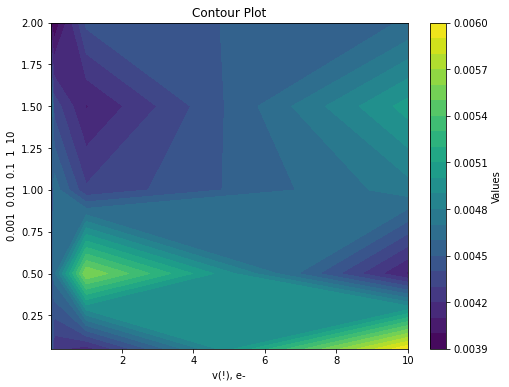

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Data from the table
v_values = [0.05, 0.5, 1, 1.5, 2]
e_values = [0.001, 0.01, 0.1, 1, 10]
data = [
    [0.004274511261, 0.0045954293, 0.0042221, 0.00415216, 0.005987208],
    [0.0049350, 0.00431524, 0.0046560, 0.0056003, 0.0040817396],
    [0.00454655, 0.00413854, 0.00466175, 0.004315476, 0.00475263],
    [0.00517842, 0.00487212, 0.00435769, 0.004091070, 0.0050430],
    [0.00469107, 0.004006047154, 0.003916094, 0.00442386605, 0.0046068933]
]

# Convert data to a NumPy array
v_values = np.array(v_values)
e_values = np.array(e_values)
data = np.array(data)

# Create a contour plot
plt.figure(figsize=(8, 6))
# contour = plt.contourf(v_values, e_values, data, levels=20, cmap='viridis')
contour = plt.contourf(e_values, v_values, data, levels=20, cmap='viridis')
plt.colorbar(contour, label='Values')
plt.xlabel('v(!), e-')
plt.ylabel('0.001  0.01  0.1  1  10')
plt.title('Contour Plot')
#plt.grid()

plt.show()


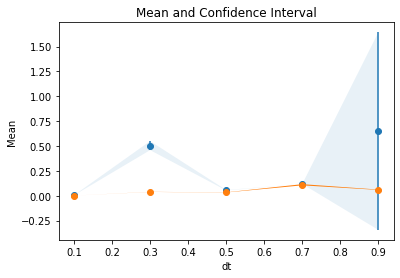

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Define your data
data = np.array([
    [0.1, 0.004594935, 0.003533, 0.0040108, 0.00472714, 0.0046558141],
    [0.3, 0.88462878, 0.5678798, 0.44142248, 0.32360147, 0.300290409],
    [0.5, 0.089806, 0.116980766, 0.04670006, 0.0085662, 0.0126315],
    [0.7, 0.0997603, 0.1249526, 0.1271880, 0.1153250438, 0.12143247],
    [0.9, 0.1721318, 0.14675536, 0.144808179, 0.1415642, 2.64384546]
])

data1 = np.array([
    [0.1, 0.00013050, 0.0002666503, 0.000046665180259764, 0.003234338, 0.0014085],
    [0.3, 0.04273750, 0.030208, 0.05416726, 0.001688055, 0.0618813],
    [0.5, 0.08075318, 0.00305555, 0.04613069, 0.023499592, 0.01064494],
    [0.7, 0.08321598, 0.0736146, 0.07003083, 0.2631810, 0.059834297],
    [0.9, 0.03300295, 0.13740758, 0.057236404, 0.00839072, 0.06202654]
])

# Calculate the mean and variance for each row starting from the second column
means = np.mean(data[:, 1:], axis=1)
variances = np.var(data[:, 1:], axis=1)

# Calculate the confidence intervals (mean - variance and mean + variance)
lower_bound = means - variances
upper_bound = means + variances


# Calculate the mean and variance for each row starting from the second column
means1 = np.mean(data1[:, 1:], axis=1)
variances1 = np.var(data1[:, 1:], axis=1)

# Calculate the confidence intervals (mean - variance and mean + variance)
lower_bound1 = means1 - variances1
upper_bound1 = means1 + variances1










# Plot the means with confidence intervals
x = data[:, 0]  # x-axis values (first column)
plt.errorbar(x, means, yerr=variances, fmt='o', label='Mean of errors')
plt.fill_between(x, lower_bound, upper_bound, alpha=0.1, label='Confidence Interval')


x1 = data1[:, 0]
plt.errorbar(x1, means1, yerr=variances1, fmt='o', label='Mean of errors')
plt.fill_between(x1, lower_bound1, upper_bound1, alpha=1, label='Confidence Interval')

plt.xlabel('dt')
plt.ylabel('Mean')
#plt.legend()
plt.title('Mean and Confidence Interval')
plt.show()


Row 1: Mean = 0.001017330696051953, Variance = 1.4720632188270024e-06, Confidence Interval = (0.0010158586328331259, 0.00101880275927078)
Row 2: Mean = 0.038136422999999996, Variance = 0.000446664049871196, Confidence Interval = (0.0376897589501288, 0.03858308704987119)
Row 3: Mean = 0.0328167904, Variance = 0.0007878579873546804, Confidence Interval = (0.03202893241264532, 0.03360464838735468)
Row 4: Mean = 0.10997534140000001, Variance = 0.005923965817852148, Confidence Interval = (0.10405137558214786, 0.11589930721785216)
Row 5: Mean = 0.0596128388, Variance = 0.0018790573581052377, Confidence Interval = (0.05773378144189476, 0.061491896158105235)


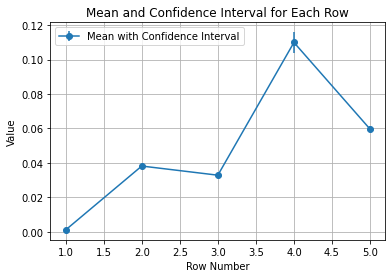

In [5]:
import numpy as np

data = np.array([
    [0.1, 0.00013050, 0.0002666503, 0.000046665180259764, 0.003234338, 0.0014085],
    [0.3, 0.04273750, 0.030208, 0.05416726, 0.001688055, 0.0618813],
    [0.5, 0.08075318, 0.00305555, 0.04613069, 0.023499592, 0.01064494],
    [0.7, 0.08321598, 0.0736146, 0.07003083, 0.2631810, 0.059834297],
    [0.9, 0.03300295, 0.13740758, 0.057236404, 0.00839072, 0.06202654]
])

# Calculate mean and variance for each row starting from the 2nd column
means = np.mean(data[:, 1:], axis=1)
variances = np.var(data[:, 1:], axis=1)

# Calculate the confidence interval (mean - variance, mean + variance)
lower_bound = means - variances
upper_bound = means + variances

# Print means, variances, and the confidence intervals
for i in range(len(means)):
    print(f"Row {i+1}: Mean = {means[i]}, Variance = {variances[i]}, Confidence Interval = ({lower_bound[i]}, {upper_bound[i]})")

import matplotlib.pyplot as plt

# Create a list of row numbers for the x-axis
row_numbers = list(range(1, len(means) + 1))

# Create a plot for the means and their confidence intervals
plt.errorbar(row_numbers, means, yerr=variances, fmt='-o', label='Mean with Confidence Interval')
plt.xlabel('Row Number')
plt.ylabel('Value')
plt.title('Mean and Confidence Interval for Each Row')
plt.legend()
plt.grid(True)
plt.show()


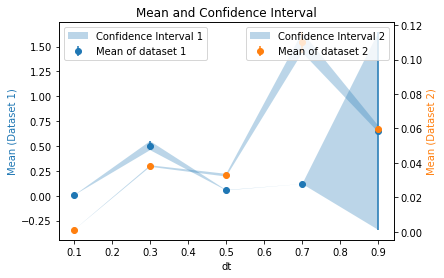

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Define your data
data = np.array([
    [0.1, 0.004594935, 0.003533, 0.0040108, 0.00472714, 0.0046558141],
    [0.3, 0.88462878, 0.5678798, 0.44142248, 0.32360147, 0.300290409],
    [0.5, 0.089806, 0.116980766, 0.04670006, 0.0085662, 0.0126315],
    [0.7, 0.0997603, 0.1249526, 0.1271880, 0.1153250438, 0.12143247],
    [0.9, 0.1721318, 0.14675536, 0.144808179, 0.1415642, 2.64384546]
])

data1 = np.array([
    [0.1, 0.00013050, 0.0002666503, 0.000046665180259764, 0.003234338, 0.0014085],
    [0.3, 0.04273750, 0.030208, 0.05416726, 0.001688055, 0.0618813],
    [0.5, 0.08075318, 0.00305555, 0.04613069, 0.023499592, 0.01064494],
    [0.7, 0.08321598, 0.0736146, 0.07003083, 0.2631810, 0.059834297],
    [0.9, 0.03300295, 0.13740758, 0.057236404, 0.00839072, 0.06202654]
])

# Calculate the mean and variance for each row starting from the second column
means = np.mean(data[:, 1:], axis=1)
variances = np.var(data[:, 1:], axis=1)

# Calculate the confidence intervals (mean - variance and mean + variance)
lower_bound = means - variances
upper_bound = means + variances

# Calculate the mean and variance for each row starting from the second column for the second dataset
means1 = np.mean(data1[:, 1:], axis=1)
variances1 = np.var(data1[:, 1:], axis=1)

# Calculate the confidence intervals (mean - variance and mean + variance) for the second dataset
lower_bound1 = means1 - variances1
upper_bound1 = means1 + variances1

# Create a figure and the first subplot
fig, ax1 = plt.subplots()

# Plot the means with confidence intervals for the first dataset
x = data[:, 0]  # x-axis values (first column)
ax1.errorbar(x, means, yerr=variances, fmt='o', label='Mean of dataset 1')
ax1.fill_between(x, lower_bound, upper_bound, alpha=0.3, label='Confidence Interval 1')
ax1.set_xlabel('dt')
ax1.set_ylabel('Mean (Dataset 1)', color='tab:blue')
ax1.legend(loc='upper left')

# Create a second y-axis on the right side
ax2 = ax1.twinx()

# Plot the means with confidence intervals for the second dataset
x1 = data1[:, 0]
ax2.errorbar(x1, means1, yerr=variances1, fmt='o', label='Mean of dataset 2', color='tab:orange')
ax2.fill_between(x1, lower_bound1, upper_bound1, alpha=0.3, label='Confidence Interval 2')
ax2.set_ylabel('Mean (Dataset 2)', color='tab:orange')
ax2.legend(loc='upper right')

plt.title('Mean and Confidence Interval')
plt.show()


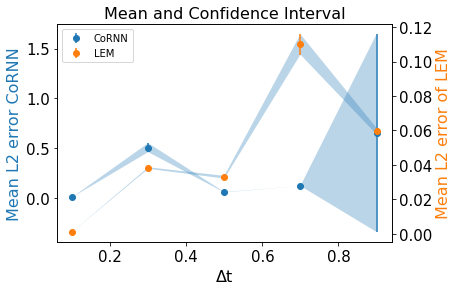

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Define your data
data = np.array([
    [0.1, 0.004594935, 0.003533, 0.0040108, 0.00472714, 0.0046558141],
    [0.3, 0.88462878, 0.5678798, 0.44142248, 0.32360147, 0.300290409],
    [0.5, 0.089806, 0.116980766, 0.04670006, 0.0085662, 0.0126315],
    [0.7, 0.0997603, 0.1249526, 0.1271880, 0.1153250438, 0.12143247],
    [0.9, 0.1721318, 0.14675536, 0.144808179, 0.1415642, 2.64384546]
])

data1 = np.array([
    [0.1, 0.00013050, 0.0002666503, 0.000046665180259764, 0.003234338, 0.0014085],
    [0.3, 0.04273750, 0.030208, 0.05416726, 0.001688055, 0.0618813],
    [0.5, 0.08075318, 0.00305555, 0.04613069, 0.023499592, 0.01064494],
    [0.7, 0.08321598, 0.0736146, 0.07003083, 0.2631810, 0.059834297],
    [0.9, 0.03300295, 0.13740758, 0.057236404, 0.00839072, 0.06202654]
])

# Calculate the mean and variance for each row starting from the second column
means = np.mean(data[:, 1:], axis=1)
variances = np.var(data[:, 1:], axis=1)

# Calculate the confidence intervals (mean - variance and mean + variance)
lower_bound = means - variances
upper_bound = means + variances

# Calculate the mean and variance for each row starting from the second column for the second dataset
means1 = np.mean(data1[:, 1:], axis=1)
variances1 = np.var(data1[:, 1:], axis=1)

# Calculate the confidence intervals (mean - variance and mean + variance) for the second dataset
lower_bound1 = means1 - variances1
upper_bound1 = means1 + variances1

# Create a figure and the first subplot
fig, ax1 = plt.subplots()

# Plot the means with confidence intervals for the first dataset
x = data[:, 0]  # x-axis values (first column)
ax1.errorbar(x, means, yerr=variances, fmt='o', label='CoRNN')
ax1.fill_between(x, lower_bound, upper_bound, alpha=0.3)
ax1.set_xlabel('$\Delta$t', fontsize=16)
ax1.set_ylabel('Mean L2 error CoRNN', color='tab:blue', fontsize=16)
ax1.legend(loc='upper left')

# Increase the axis label and tick size
ax1.tick_params(axis='both', which='both', labelsize=15)

# Create a second y-axis on the right side
ax2 = ax1.twinx()

# Plot the means with confidence intervals for the second dataset
x1 = data1[:, 0]
ax2.errorbar(x1, means1, yerr=variances1, fmt='o', label='LEM', color='tab:orange')
ax2.fill_between(x1, lower_bound1, upper_bound1, alpha=0.3)
ax2.set_ylabel('Mean L2 error of LEM', color='tab:orange', fontsize=16)

# Increase the axis label and tick size for the second y-axis
ax2.tick_params(axis='both', which='both', labelsize=15)

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Mean and Confidence Interval', fontsize=16)
#plt.savefig('Contour_Exact.pdf', dpi=500, bbox_inches="tight")
plt.savefig('Sensitivity_parameters.pdf', dpi=500, bbox_inches="tight")

plt.show()


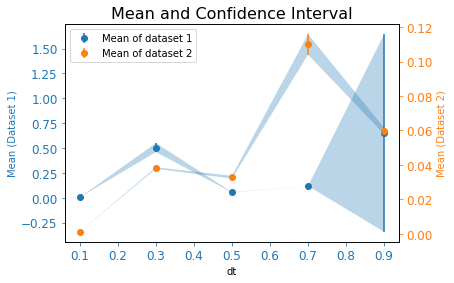

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Define your data
data = np.array([
    [0.1, 0.004594935, 0.003533, 0.0040108, 0.00472714, 0.0046558141],
    [0.3, 0.88462878, 0.5678798, 0.44142248, 0.32360147, 0.300290409],
    [0.5, 0.089806, 0.116980766, 0.04670006, 0.0085662, 0.0126315],
    [0.7, 0.0997603, 0.1249526, 0.1271880, 0.1153250438, 0.12143247],
    [0.9, 0.1721318, 0.14675536, 0.144808179, 0.1415642, 2.64384546]
])

data1 = np.array([
    [0.1, 0.00013050, 0.0002666503, 0.000046665180259764, 0.003234338, 0.0014085],
    [0.3, 0.04273750, 0.030208, 0.05416726, 0.001688055, 0.0618813],
    [0.5, 0.08075318, 0.00305555, 0.04613069, 0.023499592, 0.01064494],
    [0.7, 0.08321598, 0.0736146, 0.07003083, 0.2631810, 0.059834297],
    [0.9, 0.03300295, 0.13740758, 0.057236404, 0.00839072, 0.06202654]
])

# Calculate the mean and variance for each row starting from the second column
means = np.mean(data[:, 1:], axis=1)
variances = np.var(data[:, 1:], axis=1)

# Calculate the confidence intervals (mean - variance and mean + variance)
lower_bound = means - variances
upper_bound = means + variances

# Calculate the mean and variance for each row starting from the second column for the second dataset
means1 = np.mean(data1[:, 1:], axis=1)
variances1 = np.var(data1[:, 1:], axis=1)

# Calculate the confidence intervals (mean - variance and mean + variance) for the second dataset
lower_bound1 = means1 - variances1
upper_bound1 = means1 + variances1

# Create a figure and the first subplot
fig, ax1 = plt.subplots()

# Plot the means with confidence intervals for the first dataset
x = data[:, 0]  # x-axis values (first column)
ax1.errorbar(x, means, yerr=variances, fmt='o', label='Mean of dataset 1', color='tab:blue')
ax1.fill_between(x, lower_bound, upper_bound, alpha=0.3)
ax1.set_xlabel('dt')
ax1.set_ylabel('Mean (Dataset 1)', color='tab:blue')
ax1.legend(loc='upper left')

# Increase the axis label and tick size
ax1.tick_params(axis='both', which='both', labelsize=12, colors='tab:blue')

# Create a second y-axis on the right side
ax2 = ax1.twinx()

# Plot the means with confidence intervals for the second dataset
x1 = data1[:, 0]
ax2.errorbar(x1, means1, yerr=variances1, fmt='o', label='Mean of dataset 2', color='tab:orange')
ax2.fill_between(x1, lower_bound1, upper_bound1, alpha=0.3)
ax2.set_ylabel('Mean (Dataset 2)', color='tab:orange')

# Increase the axis label and tick size for the second y-axis
ax2.tick_params(axis='both', which='both', labelsize=12, colors='tab:orange')

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Mean and Confidence Interval', fontsize=16)
plt.show()
